# Binary Edge Switcher
#### Greedy strategy for finding the single most advantageous edge reversal for computing a given query $p(X|Y_{0},Y_{1},...,Y_{n})$ over a DAG $G$. 
- Finds the set of nodes required to compute a query, $\Delta(G,q)$,
- Finds the set of covered edges,
- Finds the covered edge which, if switched, reduces $\Delta(G,q)$ most,
- Reverses the edge and calculates updated probability tables.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Query cost
This first section of code determines the number of vertices necessary to calculate a given query, finds the set of covered edges, and returns the most advantageous reversal for a given query (measured by number ot vertices reduced in the calculation). All computations are done over a DAG $G$ with respect to a specific query $p(X|Y_{0}, Y_{1},...Y_{n})$.
- is_ancestor: checks whether one node is an ancestor of another.
- check_paths: iterates through paths to determine whether two sections of the graph are disjoint given a condition.
- find_case: determines whether a query is in the special case or general case while calculating query.
- find_covered_edges: find the set of covered edges in a graph
- is_advantageous: determines whether a reversal reduces the number of nodes needed to compute the query, returns how many the computation is reversed by. 
- best_reversal: returns the maximally advantageous reversal to reduce nodes needed in query computation. 

In [3]:
## Helper function for find_case()
## O(number_ancestors(Y)) ? Needs to find the set nx.ancestors, presumably by checking edges (therefore parents), 
## then check whether X is in that set. Should scale with the number of parents of the node linearly, ie if node has
## n parents, the check occurs n times. 

def is_ancestor(G,X,Y): #checks whether X is an ancestor of Y
    if X in nx.ancestors(G,Y):
        return(1)

In [4]:
## Helper function for find_case()
## checks for paths between targets and parents of conditions.
def check_paths(G,X,Y,cases):
    skeleton = G.to_undirected()
    y_ancestors = list(nx.ancestors(G,Y))
    paths = list(nx.all_simple_paths(skeleton, X, Y, cutoff=None)) #use skeleton so they are undirected (routes not paths).

    if len(y_ancestors) == 0:
        cases[Y] = "special" #Yj in TRIVIAL SPECIAL CASE
        return(cases)

    # The logic of the following is to find paths from X to Y: if any of them pass through an ancestor of Y
    # then there is a "back route" to Y through its ancestors, meaning there is a path connecting X to a(Y)
    # which does not pass through Y. 
    for path in paths:
        for y_ancestor in y_ancestors:
            if y_ancestor in path: #There exists a path from X to a(Y) which does not pass through Y
                cases[Y] = "general" #Yj IN GENERAL CASE
                return(cases)
            else:
                continue
            
    #Only reaches this block of code if all paths to a(Y) passed through Y; in nontrivial special case.
    cases[Y] = "special" #Yj IN SPECIAL CASE
    return(cases)


In [5]:
## Determine which case a query p(X|Ys) on a graph is in. Return the set of nodes the query depends on. 
def find_case(G,X,Ys): #Graph G, one target Xf, set of multiple conditions Ys = {y0, y1, ...}
    ## O(c*edges(G)), probably. 
    skeleton = G.to_undirected()
    
    ## O(c)
    dependent = []
    cases = {} #Dictionary with (key, value) pairs: (Y,case).
    if not nx.is_connected(skeleton): #Only consider connected graphs.
        return(0)
    if len(Ys) == 0:
        return(list(nx.ancestors(G,X)))
    
    ## O(check paths(Ys))
    for Y in Ys:
        cases = check_paths(G,X,Y,cases)
    
    ## O(shortest path) = n**2 logn +nm according according to NetworkXreference (but this is using weighted edges?),
    ## where n is number of nodes, m is number of edges
    shortest_path = nx.shortest_path(skeleton,X,Y) #use skeleton so we have shortest route (undirected)
    x_ancestors = list(nx.ancestors(G,X))
    y_ancestors = list(nx.ancestors(G,Y))
    
    ## O(number of ancestors of x)
    dependent.append(X)
    for x_ancestor in x_ancestors:
        dependent.append(x_ancestor)

    ## O (len(Ys)
    for Y in Ys:
        if cases[Y] == "general":
            for node in shortest_path:
                dependent.append(node) ##Includes all nodes on shortest route form X to Y including X and Y. 
            for y_ancestor in y_ancestors:
                dependent.append(y_ancestor)
                
        if cases[Y] == "special":
            for node in shortest_path:
                dependent.append(node)
            dependent = list(set(dependent))
            dependent.remove(Y)
            for y_ancestor in y_ancestors:
                if y_ancestor in dependent:
                    dependent.remove(y_ancestor)
    
    return(list(set(dependent)))

In [6]:
## Return the set of covered edges in a graph. Independent of query. 

# O (number_edges, number of predeccors of x, number of predeccesors y) 
## ^ growth of these with number of nodes depends on the type of graph...

def find_covered_edges(G):
    ## O(c)
    covered_edges = []
    ## O(number_edges)
    for edge in G.edges: #for edge (X,Y)
        # O(number of predecessorsx + number of predeccors y) + c
        source_parents = list(G.predecessors(edge[0])) #parents of X
        target_parents = list(G.predecessors(edge[1])) #parents of Y
        source_parents.append(edge[0]) #parents of X union X
        if set(source_parents) == set(target_parents):
            covered_edges.append(edge)
    return(covered_edges)


In [7]:
## Reverse chosen edge of a graph (only structurally, not probabilities), return altered graph

## O(G.copy) + c
def structure_reverse_edge(G, x, y):
    Grev = G.copy()
    Grev.add_edge(y,x)
    Grev.remove_edge(x,y)
    return(Grev)

In [8]:
## Given a query p(X|Ys), determine whether switching covered edge is advantageous,
## and return the number of vertices which no longer need to be computed given a possible switch
def is_advantageous(G,edge, X, Ys):
    vertex_cost_difference = 0
    cost_before = len(find_case(G, X, Ys))
    
    x = edge[0]
    y = edge[1]
    Grev = G.copy()
    Grev = structure_reverse_edge(Grev,x,y)
    cost_after = len(find_case(Grev,X,Ys))
    if cost_after < cost_before:
        vertex_cost_difference = cost_before - cost_after
    return(vertex_cost_difference)


In [9]:
## Iterates through covered edges and returns the covered edge for which
## reversal reduces the number of vertices which must be computed MOST at a given time.
def best_reversal(G, X, Ys):
    covered_edges = find_covered_edges(G) 
    edge_advantages = {}
    for edge in covered_edges:
         edge_advantages[edge] = is_advantageous(G,edge,X,Ys)
    max_adv_edge = max(edge_advantages, key=edge_advantages.get)
    return(max_adv_edge)


### Edge reversal
This second section of code does all necessary calculations to switch the pre-determined edge and update the probability tables of the DAG to reflect this change. 
- establish_switched_graph: creates a new graph which will be returned with changed structure and probabilities.
- populate_prob_dict: creates and populates (with known values) a dictionary of $X$, $p(X)$.
- calculate_reversal: calculates changed node values of $X_{1}$ and $X_{2}$ for a reversed edge $(X_{1},X_{2}) \rightarrow (X_{2}, X_{1})$.
- find_nodes_to_recalculate: determines the set of nodes which must be recalculated after reversal (note, one could maybe juust change the ones that the query depends on unless there are more queries to answer?). 
- recalculate_node: recalculates a node other than $X_{1}$ and $X_{2}$ which is affected by the reversal. 
- switch_edge_probs: main function which combines the above pieces to make a complete recalculation of the graph and return the updated one. 

## Encoding node data

In [27]:
import itertools
class NodeData:
    '''
    Attributes:
        parents: a list of strings that contains the names of the parent nodes
        conditionals: a list of size 2^p (where p is the number of parents) 
            that contains the conditional probabilities of the RV of this node given all possible values for the parents
    '''
    def __init__(self, name, parents=None, conditionals=None):
        self.name = name
        self.parents = parents

        # initializing the data structures,
        # mostly stuff that ensures that everything also works for nodes without parents
        if parents == None:
            self.num_parents = 0
        else:
            self.num_parents = len(self.parents)

        if conditionals == None:
            self.conditionals = [0 for _ in range(2**self.num_parents)]
        else:
            self.conditionals = conditionals

            
    def set_conditional(self, p, parent_assignment=None):
        '''
        parent_assignment: a dict that maps values to names of parents, e.g.
        {'x1' : 0, 'x2' : 1, 'x3' : 0, ...}
        this function computes the index of self.conditionals where the required value is stored and sets the conditional probability
        '''
        # handle special case of node without parents:
        if self.parents == None:
            self.conditionals[0] = p
            return
        # general case:
        index = 0
        for p_i in range(len(self.parents)):
            index += parent_assignment[self.parents[p_i]] * 2**p_i

        self.conditionals[index] = p

        
    def get_conditional(self, parent_assignment):
        '''
        parent_assignment: a dict that maps values to names of parents, e.g.
        {'x1' : 0, 'x2' : 1, 'x3' : 0, ...}
        this function computes the index of self.conditionals where the required value is stored and returns the conditional
        '''
        
        ##input of get conditionals is parent_assignment, dict which grows linearly with number of parents. 
        ##So we can calculate this in terms of numparsx. 
        
        # handle special case of node without parents:
        # O(c)
        if self.parents == None:
            return self.conditionals[0]
        # general case:
        #O(c)
        index = 0
        #multiplier of O(numparsx)
        for p_i in range(len(self.parents)):
            #O(numparsx)
            index += parent_assignment[self.parents[p_i]] * 2**p_i

        return self.conditionals[index]

    
    def print_conditionals(self):
        '''
        prints the full conditional distribution
        iterates through all possible assignments and prints the conditional distribution for each assignment in a seperate line
        '''
        all_possible_parent_assignments = [x for x in itertools.product([0,1], repeat=self.num_parents)]

        for a_i in range(2**self.num_parents):
            assignment = {self.parents[i] : all_possible_parent_assignments[a_i][i] for i in range(self.num_parents)}
            # some list-magic that produces a sufficiently nice string:
            assignment_string = "P("+self.name+" = 1 | " + ', '.join([str(x) + " = " + str(assignment[x]) for x in assignment]) + " ) = " + str(self.get_conditional(assignment))
            print (assignment_string)

## Generalized edge switching algorithm

In [28]:
def switch_edge(x, y):
    '''
    switches the edge (x,y) to (y,x)
    x, y: NodeData
    '''

    ## In calculating the complexity of this, I am thinking of the inputs to this as the number 
    ## of parents of x and the number of parents of y, since x and y themselves don't scale but their 
    ## parents scale depending on the density and size of the graph. 
    ## I'm calling these values numparsx and numparsy for now. I'll comment the O() of each subfunction on the side, and
    ## then quanitify them all together below.  
    
    # preparation:
    # use itertools.product to get all possible assignments of values for the parent nodes:
    
     ##O(2**(numparsx)) 
    all_possible_parent_assignments = list(itertools.product([0,1], repeat=x.num_parents))
    
    ## O(c)
    num_parents_assigments = len(all_possible_parent_assignments)

    # get conditional joint distribution p(x,y | parents):
    # initialization:
    
     ## 4 * (O(2**numparsx))
    pxe0ye0 = [0 for _ in range(2**x.num_parents)]  
    pxe0ye1 = [0 for _ in range(2**x.num_parents)]
    pxe1ye0 = [0 for _ in range(2**x.num_parents)]
    pxe1ye1 = [0 for _ in range(2**x.num_parents)]
    
    
    # iterate through all possible assignments for the common parents of x and y:
    
    ## multiplier of num_parents_assignments = 2**numparsx on this whole block of code. 
    for a_i in range(num_parents_assigments):
        
        ## 2 * O(all_possible_parent_assignments * xnumpars) = 2 * [ O(2**(xnumpars) * xnumpars) ]
        assignemnt_dict_x = {x.parents[i] : all_possible_parent_assignments[a_i][i] for i in range(x.num_parents)}
        assignemnt_dict_y = {x.parents[i] : all_possible_parent_assignments[a_i][i] for i in range(x.num_parents)}
        
        ## O(c)
        assignemnt_dict_y[x.name] = 0
        
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        # case x=0, y=1:
        pxe0ye1[a_i] = (1-x.get_conditional(assignemnt_dict_x)) * y.get_conditional(assignemnt_dict_y)
        # case x=0, y=0:
        pxe0ye0[a_i] = (1-x.get_conditional(assignemnt_dict_x)) * (1-y.get_conditional(assignemnt_dict_y))

        # O(c)
        assignemnt_dict_y[x.name] = 1
        
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        # case x=1, y=1:
        pxe1ye1[a_i] = x.get_conditional(assignemnt_dict_x) * y.get_conditional(assignemnt_dict_y)
        # case x=1, y=0:
        pxe1ye0[a_i] = x.get_conditional(assignemnt_dict_x) * (1-y.get_conditional(assignemnt_dict_y))

    ##no more multiplier.
    
    ## 6 * [ O(num_par_assignments) ] = 6*O(2**numparsx)
    # marginalize x from the conditional distribution of y:
    pye0 = [pxe0ye0[i] + pxe1ye0[i] for i in range(num_parents_assigments)]
    pye1 = [pxe0ye1[i] + pxe1ye1[i] for i in range(num_parents_assigments)]

    # condition x on the possible values of y:
    pxe0gye0 = [pxe0ye0[i]/pye0[i] for i in range(num_parents_assigments)]
    pxe0gye1 = [pxe0ye1[i]/pye1[i] for i in range(num_parents_assigments)]
    pxe1gye0 = [pxe1ye0[i]/pye0[i] for i in range(num_parents_assigments)]
    pxe1gye1 = [pxe1ye1[i]/pye1[i] for i in range(num_parents_assigments)]

    # construct new nodedata objects:
    ## O(c)
    x_new_parents = [y.name]
    ## O(c) (check x.parents == None, worst case scenario, add two values)
    if not x.parents == None:
        x_new_parents += x.parents
    ## O(c)
    x_new = NodeData(x.name, parents=x_new_parents)
    
    ##All of the following have the multiplier 2**num_parents_assignments = 2**numparsx
    for a_i in range(num_parents_assigments):
        
        ## O((2**xnumpars) * xnumpars)
        # construct the assignment-dictionary:
        assignment_dict = {x.parents[i] : all_possible_parent_assignments[a_i][i] for i in range(x.num_parents)}

        # case y=0:
        # add y to assignment_dict:
        ##O(c)
        assignment_dict[y.name] = 0
        # set conditional for x_new:
        ## O(c)
        x_new.set_conditional(p=pxe1gye0[a_i], parent_assignment=assignment_dict)

        # case y=1
        # add y to assignment_dict:
        ## O(c)
        assignment_dict[y.name] = 1
        # set conditional for x_new:
        
        ##O(c)
        x_new.set_conditional(p=pxe1gye1[a_i], parent_assignment=assignment_dict)

    ## no more multipier 
    
    ## O(c)
    y_new_parents = []
    
    ## O(c)
    if not x.parents == None:
        y_new_parents += x.parents
        
    ## O(c)
    y_new = NodeData(y.name, parents=y_new_parents)
    
    ## all have multiplier of 2**numparsx:
    for a_i in range(num_parents_assigments):
        # construct the assignment-dictionary:
        ## O((2**xnumpars) * xnumpars)
        assignment_dict = {x.parents[i] : all_possible_parent_assignments[a_i][i] for i in range(x.num_parents)}
        ## O(c)
        y_new.set_conditional(p=pye1[a_i], parent_assignment=assignment_dict)

    return x_new, y_new


##Collecting the values of all of the above:
## Inputs (x,y), we see how they scale with numparsx numparsy:

    ##O(2**(numparsx)) to assign vals.
    ## O(c)
    ## 4 * (O(2**numparsx))
        
    ## all of the following have multiplier of num_parents_assignments = 2**numparsx on this whole block of code. 
        ## 2 * O(all_possible_parent_assignments * xnumpars) = 2 * [ O(2**(xnumpars) * xnumpars) ]
        ## O(c)
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        # O(c)
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        

    ## 6 * [ O(num_par_assignments) ] = 6*O(2**numparsx)
    ## O(c)
    ## O(c) (check x.parents == None, worst case scenario, add two values)
    ## O(c)
    
    ## all of the following have the multiplier 2**num_parents_assignments = 2**numparsx
        ## O((2**xnumpars) * xnumpars)
        ##O(c)
        ## O(c)
        ## O(c)
        ## O(c)
    
    ## O(c)
    ## O(c)
    ## O(c)
    
    ## all of the following have multiplier of 2**numparsx:
        ## O((2**xnumpars) * xnumpars)
        ## O(c)

        
        
        

## = (getting rid of O(c) instances and consolidating multipliers)

    ## 5 * (O(2**numparsx))
        
    ## multiplier of 2**numparsx: 
        ## 2 * [ O(2**(xnumpars) * xnumpars) ]
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        ## 2 * [ O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy)) ]
        
    ## 6*O(2**numparsx)
    
    ## multiplier of 2**numparsx
        ## O((2**xnumpars) * xnumpars)
    
    ## multiplier of 2**numparsx:
        ## O((2**xnumpars) * xnumpars)
        

        
        
        
## = (removing constant multipliers such as 6*O(2**numparsx) = O(2**numparsx))

    ## (O(2**numparsx))
        
    ## multiplier of 2**numparsx: 
        ## O(2**(xnumpars) * xnumpars) ]
        ## O(get_conditional(2**numparsx)) + O(get_conditional(2**numparsy))
        
    ## O(2**numparsx)
    
    ## multiplier of 2**numparsx
        ## O((2**xnumpars) * xnumpars)
    
    ## multiplier of 2**numparsx:
        ## O((2**xnumpars) * xnumpars)
        
        
        
        
        
## (finding complexity of get_conditionals(2**numparsy)):

 ## From above: 
    ## O(c)
    ## O(c)
    ## multiplier of O(numparsx)
        #O(numparsx) I Feel very uncertain about this!
        # original syntax: index += parent_assignment[self.parents[p_i]] * 2**p_i
        
 ## = (complexity of get_conditionals(2**numparsx)):
   ## O(2**numparsx) ** 2
    

    
    
    
## = (now using the complexity of get_conditionals(2**numparsy)):

    ## O(2**numparsx)
        
    ## 2**numparsx * [O(2**(numparsx) * numparsx)] 
    ## 2**numparsx * ([O(2**numparsx) ** 2] + [ O(2**numparsy) ** 2])
    
    ## O(2**numparsx)
    ## 2**(numparsx) * [O((2**xnumpars) * xnumpars)]
    ## 2**numparsx *  [O((2**xnumpars) * xnumpars)]

    
## = 2x 
## + 2**x(2**x * x)
## + 2**x((2**x)**2) + (2y)**2)
## + 2**x
## + 2**x *(2**x)(x)
## + 2**x *(2**x)(x)

## = 3(x**2)**3x + 2**3x + 2**3x + 2**(x+2y) + 2x + 2**3x + x*(2**3x)
## = 3x**6x + 2**(x+2y) + 2**(3x) + 4x

## Removing constants,ignoring linear subterms since this is way more than linear, 
## (using x for numparsx, y for numparsy)
## this boils down to [x**6x] + [2 **(x+y)] + [2**x] 
## With the largest terms being O(x**x) and O(2**(x+y))

## That's horrible!! 

## Example 1

## Example
Given a DAG $G$, a query $q = p(X,Y_{0}, Y_{1}, ..., Y_{n})$ and a probability table 'node_attr_list', we:
- calculate the most advantageous edge switch for $G$ given $q$,
- calculate the new probabilities of a graph 'G_switched' with those reversals and imbue the new graph with the calculated probabilities. 

Here, the query is $p(X_{2})$ with no conditions. We expect the best switch to be $(X_{1},X_{2})$ to $(X_{2},X_{1})$, (saving the query calculation one vertex), and:
* $p(X_{1}=1|X_{2}=0) = 0.176$,
* $p(X_{1}=1|X_{2}=1) = 0.25$,
* $p(X_{2}=0) = 0.68$. 

P(x1 = 1 |  ) = 0.2
P(x2 = 1 | x1 = 0 ) = 0.3
P(x2 = 1 | x1 = 1 ) = 0.4
P(x3 = 1 | x2 = 0 ) = 0.1
P(x3 = 1 | x2 = 1 ) = 0.9


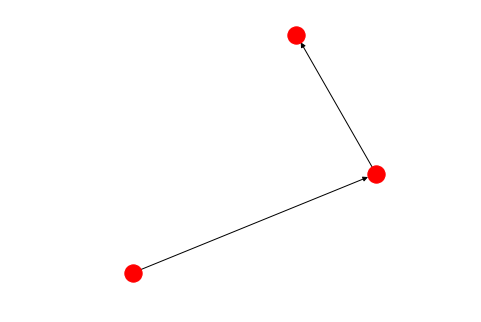

235 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
40.6 µs ± 4.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
91.9 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Best reversal: x1 x2
P(x1 = 1 | x2 = 0 ) = 0.17647058823529413
P(x1 = 1 | x2 = 1 ) = 0.25000000000000006
P(x2 = 1 |  ) = 0.32


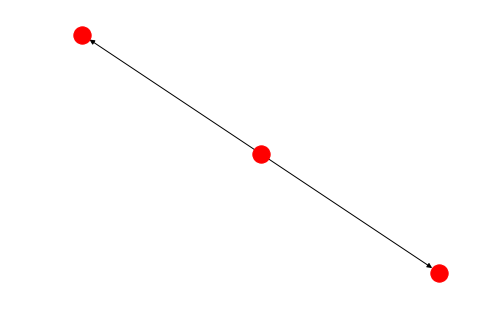

In [26]:
import time
# define graph:
x1 = NodeData('x1')
x1.set_conditional(p=0.2)

x2 = NodeData('x2', parents=['x1'])
x2.set_conditional(p=0.3, parent_assignment={'x1':0})
x2.set_conditional(p=0.4, parent_assignment={'x1':1})

x3 = NodeData('x3', parents=['x2'])
x3.set_conditional(p=0.1, parent_assignment={'x2':0})
x3.set_conditional(p=0.9, parent_assignment={'x2':1})

x1.print_conditionals()
x2.print_conditionals()
x3.print_conditionals()

nodes = [x1,x2,x3]

G = nx.DiGraph()
G.clear()
G.add_edges_from([(x1, x2), (x2, x3)]) # using a list of edge tuples
nx.draw(G)
plt.show()

## Specific to the query - find the best reversal and switch it
target = x2
conditions = []

x, y = best_reversal(G,target,conditions)
%timeit best_reversal(G,target,conditions)

x_new, y_new = switch_edge(x, y)
%timeit switch_edge(x,y)

%timeit(find_case(G, target, conditions))

print("Best reversal:", x.name, y.name)
x_new.print_conditionals()
y_new.print_conditionals()
G_new = structure_reverse_edge(G,x,y)

nx.draw(G_new)
plt.show()

### Compare how long finding the optimal reversal + calculating the reversal takes 
### compared to simply calculating without the reversal

## Example 2

P(x1 = 1 |  ) = 0.8
P(x2 = 1 | x1 = 0 ) = 0.2
P(x2 = 1 | x1 = 1 ) = 0.4
P(x3 = 1 | x1 = 0, x2 = 0 ) = 0.1
P(x3 = 1 | x1 = 0, x2 = 1 ) = 0.4
P(x3 = 1 | x1 = 1, x2 = 0 ) = 0.2
P(x3 = 1 | x1 = 1, x2 = 1 ) = 0.8


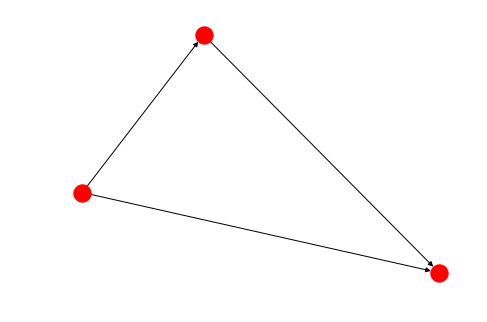

Best reversal: x1 x2
switch edge ( x1 , x2 )
P(x1 = 1 | x2 = 0 ) = 0.7500000000000001
P(x1 = 1 | x2 = 1 ) = 0.888888888888889
P(x2 = 1 |  ) = 0.36000000000000004


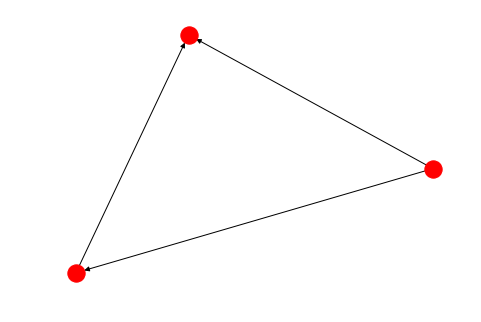

In [13]:

# define graph:
x1 = NodeData('x1')
x1.set_conditional(p=0.8)

x2 = NodeData('x2', parents=['x1'])
x2.set_conditional(p=0.2, parent_assignment={'x1':0})
x2.set_conditional(p=0.4, parent_assignment={'x1':1})

x3 = NodeData('x3', parents=['x1', 'x2'])
x3.set_conditional(p=0.1, parent_assignment={'x1': 0, 'x2': 0})
x3.set_conditional(p=0.2, parent_assignment={'x1': 1, 'x2': 0})
x3.set_conditional(p=0.4, parent_assignment={'x1': 0, 'x2': 1})
x3.set_conditional(p=0.8, parent_assignment={'x1': 1, 'x2': 1})

x1.print_conditionals()
x2.print_conditionals()
x3.print_conditionals()

nodes = [x1,x2,x3]

G = nx.DiGraph()
G.clear()
G.add_edges_from([(x1, x2), (x2, x3),(x1,x3)]) # using a list of edge tuples
nx.draw(G)
plt.show()

## Specific to the query - find the best reversal and switch it
target = x2
conditions = []
x, y = best_reversal(G,target,conditions)
print("Best reversal:", x.name, y.name)

print ("switch edge (", x.name, ",", y.name, ")")
x_new, y_new = switch_edge(x, y)
x_new.print_conditionals()
y_new.print_conditionals()
G_new = structure_reverse_edge(G,x,y)

nx.draw(G_new)
plt.show()

## Example 3

P(x1 = 1 |  ) = 0.8
P(x2 = 1 | x1 = 0 ) = 0.2
P(x2 = 1 | x1 = 1 ) = 0.4
P(x3 = 1 | x1 = 0, x2 = 0 ) = 0.1
P(x3 = 1 | x1 = 0, x2 = 1 ) = 0.4
P(x3 = 1 | x1 = 1, x2 = 0 ) = 0.2
P(x3 = 1 | x1 = 1, x2 = 1 ) = 0.8
P(x4 = 1 | x3 = 0 ) = 0.4
P(x4 = 1 | x3 = 1 ) = 0.5


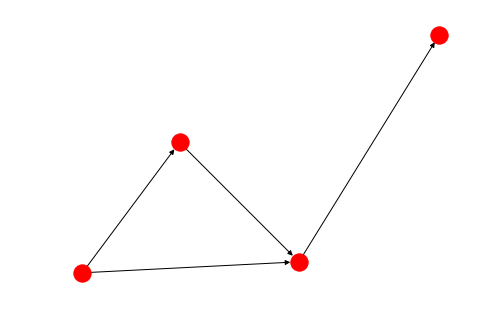

Best reversal: x1 x2
switch edge ( x1 , x2 )
P(x1 = 1 | x2 = 0 ) = 0.7500000000000001
P(x1 = 1 | x2 = 1 ) = 0.888888888888889
P(x2 = 1 |  ) = 0.36000000000000004


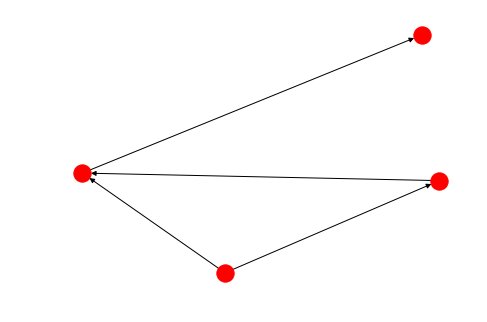

In [14]:

# define graph:
x1 = NodeData('x1')
x1.set_conditional(p=0.8)

x2 = NodeData('x2', parents=['x1'])
x2.set_conditional(p=0.2, parent_assignment={'x1':0})
x2.set_conditional(p=0.4, parent_assignment={'x1':1})

x3 = NodeData('x3', parents=['x1', 'x2'])
x3.set_conditional(p=0.1, parent_assignment={'x1': 0, 'x2': 0})
x3.set_conditional(p=0.2, parent_assignment={'x1': 1, 'x2': 0})
x3.set_conditional(p=0.4, parent_assignment={'x1': 0, 'x2': 1})
x3.set_conditional(p=0.8, parent_assignment={'x1': 1, 'x2': 1})

x4 = NodeData('x4', parents=['x3'])
x4.set_conditional(p=0.4, parent_assignment={'x3': 0})
x4.set_conditional(p=0.5, parent_assignment={'x3': 1})

x1.print_conditionals()
x2.print_conditionals()
x3.print_conditionals()
x4.print_conditionals()

nodes = [x1,x2,x3,x4]

G = nx.DiGraph()
G.clear()
G.add_edges_from([(x1, x2),(x2, x3),(x1, x3),(x3, x4)]) # using a list of edge tuples
nx.draw(G)
plt.show()

## Specific to the query - find the best reversal and switch it
target = x2
conditions = []
x, y = best_reversal(G,target,conditions)
print("Best reversal:", x.name, y.name)

print ("switch edge (", x.name, ",", y.name, ")")
x_new, y_new = switch_edge(x, y)
x_new.print_conditionals()
y_new.print_conditionals()
G_new = structure_reverse_edge(G,x,y)

nx.draw(G_new)
plt.show()